# 3D synthetic model & observations TEST
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np

from tqdm                 import tqdm
from astropy              import units, constants
from scipy.interpolate    import griddata

from pomme.utils       import convert_angular_to_spatial
from pomme.plot        import plot_cube_2D
from pomme.object      import AstroObject
from pomme.observation import DataCube

from pomme.model       import TensorModel, SphericallySymmetric
from pomme.utils       import print_var, interpolate
from pomme.lines       import Line
from pomme.loss        import Loss, fourier_loss_1D, fourier_loss_1D
from pomme.haar        import Haar

In [2]:
# File name
input_file = "/STER/frederikd/Magritte-examples/Phantom_3D/model_Phantom_3D.ascii"

# Read the Phantom ascii file
(x,y,z, h, rho, v_x,v_y,v_z, u) = np.loadtxt(input_file, skiprows=14, usecols=(0,1,2,4,5,6,7,8,9), unpack=True)

# Constants that can be read from ascii file
velocity_cte = 2.9784608e+06
density_cte  = 5.9410314e-07
energy_cte   = 8.8712277e+12

keep = np.logical_and(h>0.0, rho>0.0)

# Exclude unphysical points and points with zero abundance
x   = x  [keep]
y   = y  [keep]
z   = z  [keep]
v_x = v_x[keep]
v_y = v_y[keep]
v_z = v_z[keep]
u   = u  [keep]
rho = rho[keep]

# Extract the number of points
npoints = len(x)

# Convert rho (total density) to abundances
nH2 = rho * density_cte * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Convert to m/s
v_x *= velocity_cte * 0.01
v_y *= velocity_cte * 0.01
v_z *= velocity_cte * 0.01

position = np.array((x, y, z)).transpose()

# Convert units
position *= constants.au.si.value   # Convert au to m

# Derive temperature from internal energy (assuming adiabatic heating/cooling)
gamma = 1.2
mu    = 2.381
tmp   = mu * (gamma-1.0) * u * energy_cte * 1.00784 * (units.erg/units.g * constants.u/constants.k_B).to(units.K).value

# Cut-off temperatures below 2.725 K
tmp[tmp<2.725] = 2.725

# Define turbulence at 150 m/s
trb = 150.0

# Map point data to a regular grid
haar = Haar(position, q=7)

# nCO_dat = haar.map_data(nCO, interpolate=True)[-1][8:56,8:56,8:56]
# tmp_dat = haar.map_data(tmp, interpolate=True)[-1][8:56,8:56,8:56]
# v_x_dat = haar.map_data(v_x, interpolate=True)[-1][8:56,8:56,8:56]
# v_y_dat = haar.map_data(v_y, interpolate=True)[-1][8:56,8:56,8:56]
# v_z_dat = haar.map_data(v_z, interpolate=True)[-1][8:56,8:56,8:56]

# nCO_dat = haar.map_data(nCO, interpolate=True)[-1][17:111,17:111,17:111]
# tmp_dat = haar.map_data(tmp, interpolate=True)[-1][17:111,17:111,17:111]
# v_x_dat = haar.map_data(v_x, interpolate=True)[-1][17:111,17:111,17:111]
# v_y_dat = haar.map_data(v_y, interpolate=True)[-1][17:111,17:111,17:111]
# v_z_dat = haar.map_data(v_z, interpolate=True)[-1][17:111,17:111,17:111]

# nCO_dat = haar.map_data(nCO, interpolate=True)[-1][32:224,32:224,32:224]
# tmp_dat = haar.map_data(tmp, interpolate=True)[-1][32:224,32:224,32:224]
# v_x_dat = haar.map_data(v_x, interpolate=True)[-1][32:224,32:224,32:224]
# v_y_dat = haar.map_data(v_y, interpolate=True)[-1][32:224,32:224,32:224]
# v_z_dat = haar.map_data(v_z, interpolate=True)[-1][32:224,32:224,32:224]

nCO_dat = haar.map_data(nCO, interpolate=True)[-1]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1]

In [3]:
# reduce = lambda a: 0.25*(a[0::2,0::2,:] + a[1::2,0::2,:] + a[0::2,1::2,:] + a[1::2,1::2,:])

# nCO_dat = reduce(nCO_dat)
# tmp_dat = reduce(tmp_dat)
# v_x_dat = reduce(v_x_dat)
# v_y_dat = reduce(v_y_dat)
# v_z_dat = reduce(v_z_dat)

# nCO_dat = reduce(nCO_dat)
# tmp_dat = reduce(tmp_dat)
# v_x_dat = reduce(v_x_dat)
# v_y_dat = reduce(v_y_dat)
# v_z_dat = reduce(v_z_dat)

In [4]:
plot_cube_2D(np.log(nCO_dat))

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [5]:
assert tmp_dat.shape == nCO_dat.shape
assert tmp_dat.shape == v_z_dat.shape

tm = TensorModel(shape=nCO_dat.shape, sizes=haar.xyz_L)
tm['log_CO'         ]  = np.log(nCO_dat)
tm['log_temperature']  = np.log(tmp_dat)
tm['velocity_z']       =        v_z_dat
tm['log_v_turbulence'] = np.log(np.array([trb]))

In [6]:
vel = np.array((v_x_dat.reshape(-1), v_y_dat.reshape(-1), v_z_dat.reshape(-1))).T
pos = np.moveaxis(tm.get_coords(), 0, -1).reshape(-1, 3)
nCO = nCO_dat.reshape(-1)
tmp = tmp_dat.reshape(-1)

# np.save("nCO", nCO_dat)
# np.save("tmp", tmp_dat)
# np.save("vel", vel_dat)
# np.save("pos", pos_dat)

# pos_dat = model.get_coords().T
# np.save("pos_cube", pos_dat)

In [7]:
pos_min = np.min(pos, axis=0)
pos_max = np.max(pos, axis=0)

bdy = []
for i in range(3):
    bdy += list(np.where(pos[:,i] == pos_max[i])[0])
    bdy += list(np.where(pos[:,i] == pos_min[i])[0]) 
bdy = sorted(set(bdy))

In [8]:
import magritte.core  as magritte
import magritte.setup as setup

In [9]:
# Magritte setup
modelFile = "magritte_model.hdf5"
lamdaFile = "data/co.txt"
dimension = 3
npoints   = pos.shape[0]
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 100

print("npoints:", npoints)

npoints: 262144


In [10]:
mm = magritte.Model ()
mm.parameters.set_spherical_symmetry(False)
mm.parameters.set_model_name        (modelFile)
mm.parameters.set_dimension         (dimension)
mm.parameters.set_npoints           (npoints)
mm.parameters.set_nrays             (nrays)
mm.parameters.set_nspecs            (nspecs)
mm.parameters.set_nlspecs           (nlspecs)
mm.parameters.set_nquads            (nquads)

ones  = np.ones (npoints)
zeros = np.zeros(npoints)

mm.geometry.points.position.set(pos)
mm.geometry.points.velocity.set(vel/constants.c.si.value)

mm.chemistry.species.abundance = np.array((zeros, nCO, nCO, zeros, ones)).T
mm.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

mm.thermodynamics.temperature.gas  .set( tmp)
mm.thermodynamics.turbulence.vturb2.set((trb/magritte.CC)**2 * np.ones(npoints))

mm.parameters.set_nboundary(len(bdy))
mm.geometry.boundary.boundary2point.set(bdy)

direction = np.array([[0,0,+1], [0,0,-1]])         # Comment out to use all directions
mm.geometry.rays.direction.set(direction)          # Comment out to use all directions
mm.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

mm = setup.set_Delaunay_neighbor_lists (mm)
mm = setup.set_boundary_condition_zero (mm)
mm = setup.set_linedata_from_LAMDA_file(mm, lamdaFile, {'considered transitions': [0]})
mm = setup.set_quadrature              (mm)

mm.write()
mm.read ()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...
                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = magritte_model.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence.

In [11]:
mm.compute_spectral_discretisation ()
mm.compute_inverse_line_widths     ()
mm.compute_LTE_level_populations   ()

Computing spectral discretisation...
Computing inverse line widths...
Computing LTE level populations...


0

In [65]:
fcen = mm.lines.lineProducingSpecies[0].linedata.frequency[0]
vpix = 750   # velocity pixel size [m/s]
dd   = vpix * (mm.parameters.nfreqs()-1)/2 / magritte.CC
fmin = fcen - fcen*dd
fmax = fcen + fcen*dd

mm.compute_spectral_discretisation (fmin, fmax, 100)
# mm.compute_image_new(0, tm.shape[0], tm.shape[1])
mm.compute_image_new(0.0, 0.0, +1.0, tm.shape[0], tm.shape[1])
# mm.compute_image(0)

Computing spectral discretisation...

0


Computing image new...


In [66]:
model    = mm
image_nr = -1
zoom     = 1.0  
npix_x   = tm.shape[0]
npix_y   = tm.shape[1]
method   = 'nearest'

# Extract data of last image
imx = np.array(model.images[image_nr].ImX)
imy = np.array(model.images[image_nr].ImY)
imI = np.array(model.images[image_nr].I)

In [67]:
# Extract the number of frequency bins
nfreqs = model.images[image_nr].nfreqs

# Set image boundaries
deltax = (np.max(imx) - np.min(imx))/zoom
midx = (np.max(imx) + np.min(imx))/2.0
deltay = (np.max(imy) - np.min(imy))/zoom
midy = (np.max(imy) + np.min(imy))/2.0

x_min, x_max = midx - deltax/2.0, midx + deltax/2.0
y_min, y_max = midy - deltay/2.0, midy + deltay/2.0

# Create image grid values
xs = np.linspace(x_min, x_max, npix_x)
ys = np.linspace(y_min, y_max, npix_y)

# Extract the spectral / velocity data
freqs = np.array(model.images[image_nr].freqs)
f_ij  = np.mean(freqs)
# velos = (freqs - f_ij) / f_ij * constants.c.to(v_unit).value

# Interpolate the scattered data to an image (regular grid)
Is = np.zeros((nfreqs))
zs = np.zeros((nfreqs, npix_x, npix_y))
for f in range(nfreqs):
    # Nearest neighbor interpolate scattered image data
    zs[f] = griddata(
        (imx, imy),
        imI[:,f],
        (xs[None,:], ys[:,None]),
        method=method,
        fill_value = 0.0 #for non-nearest neighbor interpolation, otherwise the ceil/floor functions will complain
    )
    Is[f] = np.sum(zs[f])
Is = Is / np.max(Is)

# Put zero/negative values to the smallest positive value
zs[zs<=0.0] = np.min(zs[zs>0.0])
# Put nan values to smallest positive value
zs[np.isnan(zs)] = np.min(zs[zs>0.0])

In [68]:
plot_cube_2D(np.log(zs[:,1:-1,1:-1].T))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [69]:
import torch
import torch.nn as nn

from torch.optim import Adam

In [70]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [71]:
line = Line('CO', 0)

You have selected line:
    CO(J=1-0)
Please check the properties that were inferred:
    Frequency         1.152712018e+11  Hz
    Einstein A coeff  7.203000000e-08  1/s
    Molar mass        28.0101          g/mol


In [72]:
from astropy import constants

CC  = constants.c  .si.value   # Speed of light       [m/s]

def get_doppler_shifted_frequencies(v_los, frequencies):
    """
    Doppler shifts frequencies given the velocity along the line of sight.
    """
    # Compute the Doppler shift for each cell
    shift = 1.0 + v_los * (1.0 / CC)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, frequencies)
    
    return freqs

In [73]:
from time import time

def forward(model, freqs):
    """
    Forward model: image the given TensorModel at the given frequencies.
    """
    # t =- time()
    nCO    = torch.exp(model['log_CO'])         
    tmp    = torch.exp(model['log_temperature'])
    vel    =           model['velocity_z']
    v_turb = torch.exp(model['log_v_turbulence'])
    # t += time()
    # print("init       ", t)

    # t =- time()
    frequencies = get_doppler_shifted_frequencies(vel, freqs)
    # t += time()
    # print("Doppler    ", t)
    
    # Compute the LTE line emissivity and opacity, and the line profile
    # t =- time()
    eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)
    # t += time()
    # print("eta, chi    ", t)
    
    # Create an image of the line
    # t =- time()
    img = model.create_image(eta, chi, axis=2)
    # t += time()
    # print("create image", t)
    
    # Convolve with beam
    # img = convolve_with_beam(img)
    
    # Resolved out flux
    # img = resolved_out_flux(img)
    
    return img

In [74]:
N_freqs = 100
v_pixel = 750.0

# dd    = (N_freqs-1)/2 * v_pixel/constants.c.si.value
# fmin  = line.frequency - line.frequency*dd
# fmax  = line.frequency + line.frequency*dd
freqs = torch.linspace(fmin, fmax, N_freqs, dtype=torch.float64)

In [75]:
with torch.no_grad():
    img_p = forward(tm, freqs)

In [76]:
# img_m = zs[:,1:-1,1:-1].T
img_m = zs.T

In [77]:
plot_cube_2D(np.log(np.clip(img_p, 1.0e-30, np.inf)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [78]:
plot_cube_2D(np.log(np.clip(img_m[1:-1,1:-1,:], 1.0e-30, np.inf)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [79]:
img_p.shape

torch.Size([64, 64, 100])

In [81]:
from ipywidgets import interact

def plot(f):
    
    fig, axs = plt.subplots(2,1, dpi=250)
    axs[0].imshow(np.log(zs[f,1:-1,1:-1]).T)
    axs[1].imshow(np.log(img_p[:,:,100-f]))


interact(plot, f=(0,99))

interactive(children=(IntSlider(value=49, description='f', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [68]:
nCO_dat.shape

(64, 64, 64)

In [72]:
# plot_cube_2D(np.transpose(np.log(nCO_dat), axes=[1,0,2]))
plot_cube_2D(np.log(nCO_dat))

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [26]:
from ipywidgets    import interact

def plot_spectrum(cube_m, cube_p):
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.plot(freqs, cube_m[i,j,:])
        plt.plot(freqs, cube_p[i,j,:])
        plt.ylim((1.0e-30, 1.0e+1))
        plt.yscale('log')
        plt.axvline(line.frequency, c='k')

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, cube_m.shape[0]-1),
                    j=(0, cube_m.shape[1]-1) )

plot_spectrum(img_m, img_p)

interactive(children=(IntSlider(value=31, description='i', max=63), IntSlider(value=31, description='j', max=6…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [27]:
obs = img_p
fqs = freqs

def half_resolution(x):
    return 0.25*(x[0::2,0::2,:] + x[0::2,1::2,:] + x[1::2,0::2,:] + x[1::2,1::2,:])

# Create a list of hiearchically reduced observations
obs_list = [obs]
while obs.shape[0]/2 >= 10:
    obs = half_resolution(obs)
    obs_list.append(obs)

for i, obs in enumerate(obs_list):
    print(f'obs_list[{i}].shape =', list(obs.shape))

obs_list[0].shape = [32, 32, 100]
obs_list[1].shape = [16, 16, 100]


In [28]:
plot_cube_2D(np.log(np.clip(obs, 1.0e-30, np.inf)))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [29]:
shape = (obs.shape[0], obs.shape[1], 128)
sizes = haar.xyz_L

In [150]:
model = TensorModel(
    sizes  = sizes,
    shape  = shape,
)

model['log_CO'          ] = np.log(1.0e+8) * np.ones(model.shape)
model['log_temperature' ] = np.log(5.0e+2) * np.ones(model.shape)
model['velocity_z'      ] =        0.0     * np.ones(model.shape)
model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape)

loss              = Loss(['rep'])#, 'reg'])
loss_verification = Loss(['ver'])

for i in range(model.shape[0]):
    for j in range(model.shape[1]):
        model['velocity_z'][i,j,:] = torch.linspace(-3.0e+4, +3.0e+4, model.shape[2])

model.free_all()
model.fix('log_v_turbulence')

model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +1.842e+01     +1.842e+01     +1.842e+01
  log_temperature            Free          True     +6.215e+00     +6.215e+00     +6.215e+00
  velocity_z                 Free          True     -3.000e+04     +0.000e+00     +3.000e+04
  log_v_turbulence           Fixed         True     +5.011e+00     +5.011e+00     +5.011e+00
sizes: [5.97037805e+13 5.96945095e+13 5.97372017e+13]
shape: (12, 12, 128)


In [151]:
# def fourier_loss_3D(arr):
    
#     arr_min = arr.min()
#     arr_max = arr.max()
    
#     if arr_min != arr_max:
#         arr = (arr - arr_min) * (1.0 / (arr_max - arr_min))
    
#     fft = torch.abs(torch.fft.fftn(arr))
#     # fft[(0,)*fft.dim()] = 0.0
#     fft = fft / fft[(0,)*fft.dim()]
    
#     wgt = np.indices(fft.shape)
#     wgt = (wgt.T - 0.5*np.array(fft.shape)).T
#     wgt = np.linalg.norm(wgt, axis=0)
    
#     wgt = torch.from_numpy(wgt)

#     loss = torch.mean((torch.fft.fftshift(fft)*wgt)**2)

#     return loss

def fourier_loss_3D(arr):
    
    fft = torch.abs(torch.fft.fftn(arr))
    
    wgt = np.indices(fft.shape)
    wgt = (wgt.T - 0.5*np.array(fft.shape)).T
    wgt = np.linalg.norm(wgt, axis=0)
    
    wgt = torch.from_numpy(wgt)

    loss = torch.mean((torch.fft.fftshift(fft)*wgt)**2)
    
    return loss

In [152]:
print(f'max obs = {obs.max().item()                  :1.2e}')
print(f'max img = {forward(model, freqs).max().item():1.2e}')

max obs = 1.86e-17
max img = 1.84e-18


In [153]:
def logg(x):
    return torch.log(1.0e-30 + x)

def fit(loss, model, obs, N_epochs=10, lr=1.0e-1, w_rep=1.0, w_reg=1.0):

    optimizer = Adam(model.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward(model, freqs)
 
        # Compute the reproduction loss
        # loss['rep']              = w_rep * nn.functional.mse_loss(logg(img), logg(obs))
        loss['rep']              =   logg( nn.functional.mse_loss(     img,       obs ))
        loss_verification['ver'] =         nn.functional.mse_loss(     img,       obs ) 
        # Compute the regularisation loss
        # loss['reg'] = w_reg * model.apply_to_fields(fourier_loss_3D)
    
        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

In [146]:
fit(loss, model, obs, N_epochs=90, lr=1.0e-1, w_rep=1.0)

# loss.plot()

100%|██████████| 90/90 [00:03<00:00, 27.52it/s]


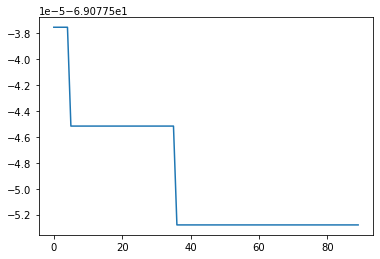

In [147]:
plt.plot(loss.losses_tot)

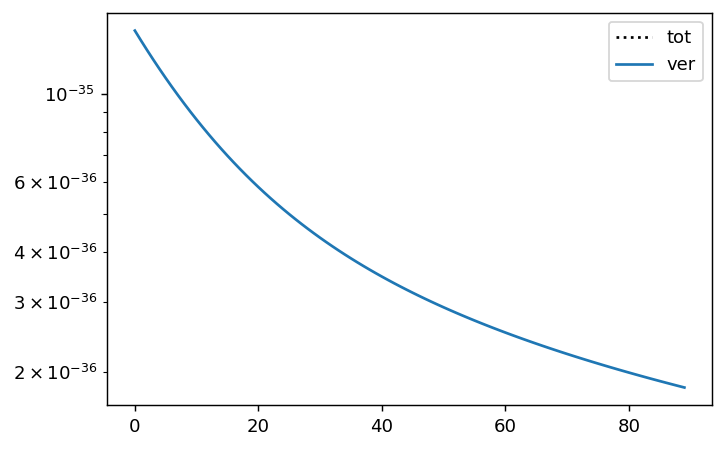

In [148]:
loss_verification.plot()

In [154]:
img = forward(model, freqs)


def plot_spectrum(cube_m, cube_p):
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function

    velos = (freqs / line.frequency - 1.0) * constants.c.si.value

    def plot(i,j):
        plt.figure(dpi=150)
        plt.plot(velos, cube_m[i,j,:], label='img')
        plt.plot(velos, cube_p[i,j,:], label='obs')
        plt.ylim((1.0e-30, 1.0e+1))
        plt.yscale('log')
        # plt.axvline(line.frequency, c='k')
        plt.legend()

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, cube_m.shape[0]-1),
                    j=(0, cube_m.shape[1]-1) )

plot_spectrum(img.data, obs)

interactive(children=(IntSlider(value=5, description='i', max=11), IntSlider(value=5, description='j', max=11)…

<function __main__.plot_spectrum.<locals>.plot(i, j)>

In [45]:
print_var('img', img)

img +0.00e+00 +5.27e-20 +1.80e-17


  0%|                                             | 0/1000 [00:00<?, ?it/s]/home/frederikd/.conda/envs/magritte/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████████████████████████████| 1000/1000 [00:06<00:00, 160.46it/s]


interactive(children=(IntSlider(value=16, description='z', max=33), Output()), _dom_classes=('widget-interact'…

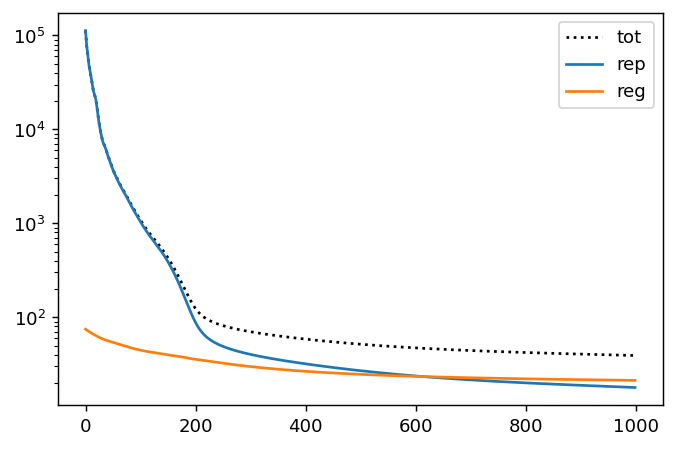

In [30]:
fit(loss, model_3D, obs, N_epochs=1000, lr=1.0e-2, w_rep=1.0, w_reg=1.0e+3)

loss.plot()

In [31]:
print_diff(model_3D_old, model_3D)

Variable:                 Min:          Mean:         Max:
  log_CO                    2.532e-04     2.125e+00     6.484e+00
  log_temperature           1.821e-02     1.483e+00     3.552e+00
  log_v_los                 5.917e-02     5.917e-02     5.917e-02
  log_v_turbulence          9.570e-02     9.570e-02     9.570e-02
  velocity_z                3.033e-03     2.148e+00     4.864e+00


In [32]:
plot_cube_2D(model_3D['log_CO'].data)

interactive(children=(IntSlider(value=127, description='z', max=255), Output()), _dom_classes=('widget-interac…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [33]:

def plot_spectrum(cube):
    """
    Plot spectrum at a pixel for this observation.
    """
    # Define a plot function
    def plot(i,j):
        plt.figure(dpi=150)
        plt.step(self.fs, self.img[:,i,j])
        plt.ylim((cube.min(), cube.max()))
        plt.xlabel(f'frequency [{self.f_unit}]')
        plt.ylabel(f'intensity [{self.I_unit}]')

    # Return an interactive ipywidget
    return interact(plot,
                    i=(0, cube.shape[0]-1),
                    j=(0, cube.shape[1]-1) )

In [34]:
img = forward(model_3D)

plot_cube_2D(img)

interactive(children=(IntSlider(value=16, description='z', max=33), Output()), _dom_classes=('widget-interact'…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [35]:
# Define a plot function
def plot(i,j):
    plt.figure(dpi=150)
    plt.step(np.arange(img.shape[2]), img[i,j,:].data)
    plt.step(np.arange(obs.shape[2]), obs[i,j,:].data)
    plt.ylim((obs.min(), obs.max()))

# Return an interactive ipywidget
interact(plot,
         i=(0, img.shape[0]-1),
         j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='j', max=0), …

<function __main__.plot(i, j)>

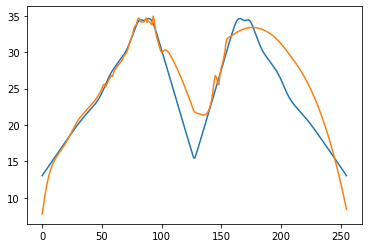

In [36]:
plt.plot(model_3D_old['log_CO'][0,0].data)
plt.plot(model_3D    ['log_CO'][0,0].data)

In [37]:
fourier_loss_3D(model_3D['log_CO'])

tensor(0.0061, dtype=torch.float64, grad_fn=<MeanBackward0>)

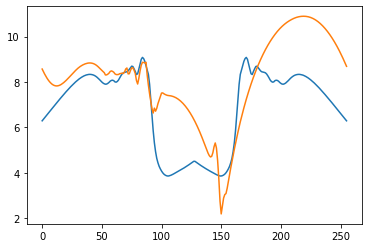

In [38]:
plt.plot(model_3D_old['log_temperature'][0,0].data)
plt.plot(model_3D    ['log_temperature'][0,0].data)

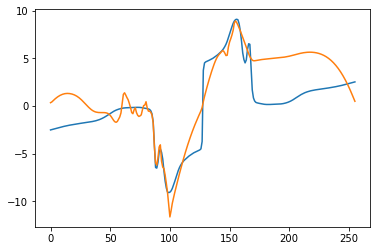

In [39]:
plt.plot(model_3D_old['velocity_z'][0,0].data)
plt.plot(model_3D    ['velocity_z'][0,0].data)

In [40]:
for obs in obs_list:
    print(obs.shape)

torch.Size([128, 128, 34])
torch.Size([64, 64, 34])
torch.Size([32, 32, 34])
torch.Size([16, 16, 34])
torch.Size([8, 8, 34])
torch.Size([4, 4, 34])
torch.Size([2, 2, 34])
torch.Size([1, 1, 34])


In [80]:
shape_z = 256

models = [model_3D]
losses = [loss]

for obs in obs_list:
    models.insert(0, TensorModel(
        sizes  = (size_x, size_y, size_z),
        shape  = (obs.shape[0], obs.shape[1], shape_z),
    ))
    losses.insert(0, Loss(['rep', 'reg']))

In [86]:
for model in models:
    print(model.shape)

(1, 1, 256)
(2, 2, 256)
(4, 4, 256)
(8, 8, 256)
(16, 16, 256)
(32, 32, 256)
(64, 64, 256)
(128, 128, 256)
(1, 1, 256)


In [113]:
model_3D.save(f"pomme_IK_Tau_0.hdf5")

In [114]:
shape_z = 64

models = [model_3D]
losses = [loss]

for obs in reversed(obs_list[:-1]):
    
    model = TensorModel(
        sizes  = (size_x, size_y, size_z),
        shape  = (obs.shape[0], obs.shape[1], shape_z),
    )
    loss = Loss(['rep', 'reg'])
                          
    print(obs.shape)
    model.interpolate_from_model(models[0])
    model.free_all()
    model.save(f"pomme_IK_Tau_{len(models)}.hdf5")

    fit(loss, model, obs, N_epochs=1000, lr=1.0e-2, w_rep=1.0, w_reg=1.0e+3)
                          
    models.insert(0, model)
    losses.insert(0, loss)

torch.Size([2, 2, 34])


100%|█████████████████████████████████| 1000/1000 [00:09<00:00, 102.82it/s]


torch.Size([4, 4, 34])


100%|██████████████████████████████████| 1000/1000 [00:10<00:00, 93.74it/s]


torch.Size([8, 8, 34])


100%|██████████████████████████████████| 1000/1000 [00:11<00:00, 87.07it/s]


torch.Size([16, 16, 34])


100%|██████████████████████████████████| 1000/1000 [00:20<00:00, 49.53it/s]


torch.Size([32, 32, 34])


100%|██████████████████████████████████| 1000/1000 [08:48<00:00,  1.89it/s]


torch.Size([128, 128, 34])


100%|██████████████████████████████████| 1000/1000 [39:46<00:00,  2.39s/it]


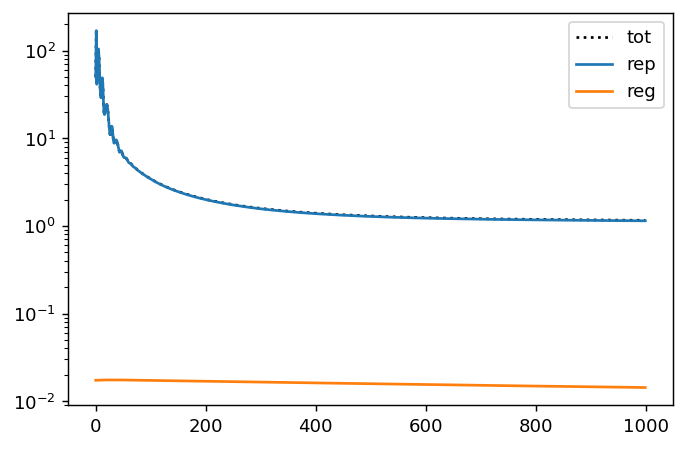

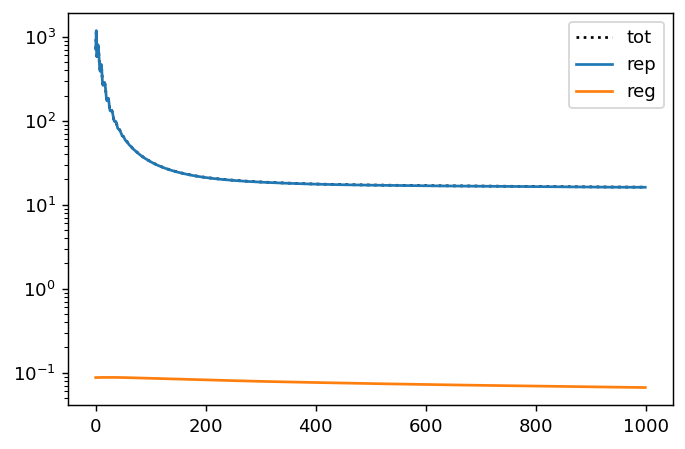

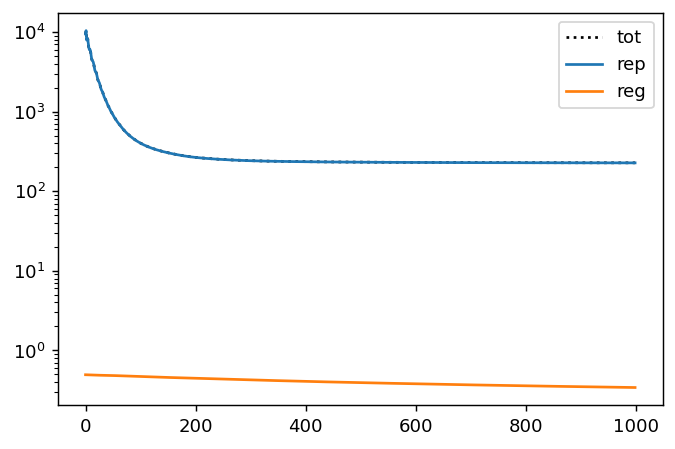

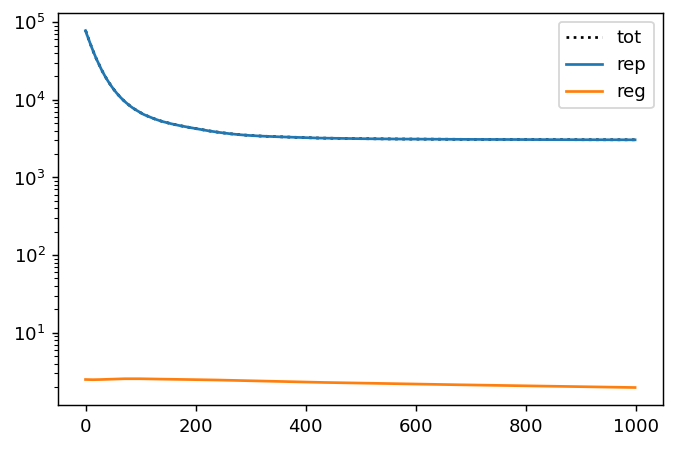

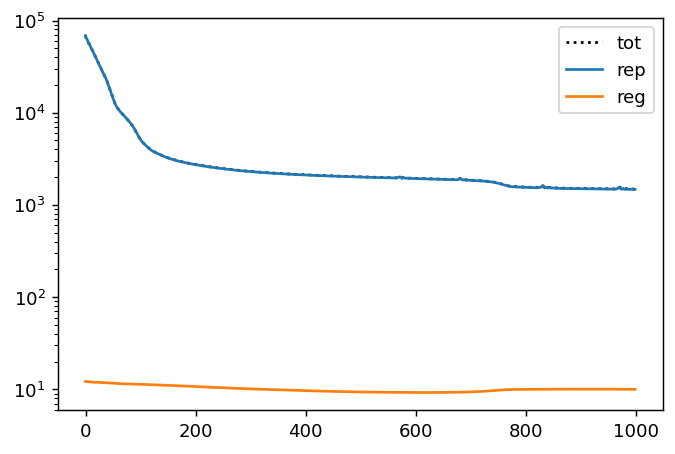

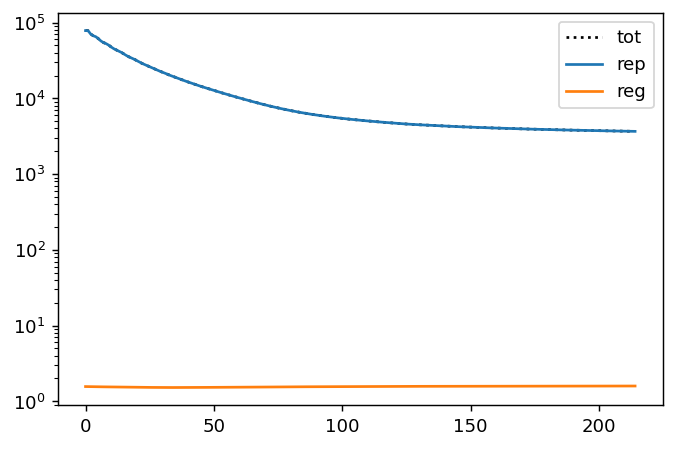

In [96]:
for loss in losses:
    loss.plot()

In [93]:
for m in models:
    print(m.shape)

(128, 128, 256)
(64, 64, 256)
(32, 32, 256)
(16, 16, 256)
(8, 8, 256)
(4, 4, 256)
(2, 2, 256)
(1, 1, 256)


In [53]:
for 

model_3D_2.interpolate_from_model(model_3D_)
model_3D_2.free_all()

loss = Loss(['rep', 'reg'])

In [59]:
model_3D_2.vars

{}

In [54]:
fit(model_3D_2, obs, N_epochs=1000, lr=1.0e-2, w_rep=1.0, w_reg=1.0e+3)

loss.plot()

ValueError: optimizer got an empty parameter list

In [103]:
n = -6

img = forward(models[n])
obs = obs_list[n]

# Define a plot function
def plot(i,j):
    plt.figure(dpi=150)
    plt.step(np.arange(img.shape[2]), img[i,j,:].data)
    plt.step(np.arange(obs.shape[2]), obs[i,j,:].data)
    plt.ylim((obs.min(), obs.max()))

# Return an interactive ipywidget
interact(plot,
         i=(0, img.shape[0]-1),
         j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=15, description='i', max=31), IntSlider(value=15, description='j', max=3…

<function __main__.plot(i, j)>

In [112]:
plot_cube_2D(models[-5]['log_CO'].T)

/tmp/ipykernel_3126811/1843582017.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plot_cube_2D(models[-5]['log_CO'].T)


interactive(children=(IntSlider(value=7, description='z', max=15), Output()), _dom_classes=('widget-interact',…

<function pomme.plot.plot_cube_2D.<locals>.plot(z)>

In [106]:
import k3d

In [111]:
dat = models[-5]['log_CO'].data
# dat = obs_list[-5].data
dat = np.array(dat, dtype=np.float32)

plt_mip = k3d.mip(dat)

plot = k3d.plot()
plot += plt_mip
plot.display()

Output()